<a href="https://colab.research.google.com/github/leinaxd/Portfolio/blob/main/machine_learning/Optimizers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

ADVERSARIAL TRAINING
```
Author: Eichenbaum Daniel
Email: eichenbaum.daniel@gmail.com
```

This is a practical demo for understanding the theory behind:
  ```
  Chapter: 7.13 Adversarial training

  Goodellow and Bengio,
  Deep Learning, MIT Press, 2016
  http://www.deeplearningbook.org
  ```

Sources:
  - Adversarial Training

  https://github.com/ndb796/Pytorch-Adversarial-Training-CIFAR

  - Deep dream github

  https://github.com/gordicaleksa/pytorch-deepdream/blob/master/deepdream.py

In [1]:
import torch, torchvision
from torch import nn, optim
from torch.nn import functional as F

import matplotlib.pyplot as plt
import numpy as np

DOWNLOAD CIFAR DATASET

100%|██████████| 170498071/170498071 [00:01<00:00, 104800909.14it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


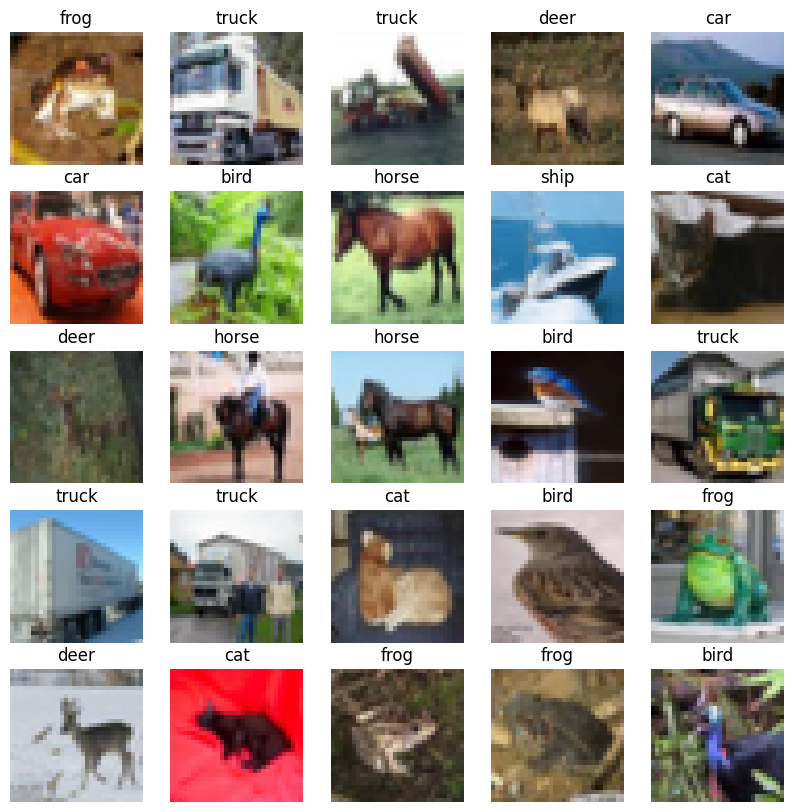

In [2]:
from torchvision.datasets import CIFAR10
from torchvision import datasets
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.transforms import RandomCrop, RandomHorizontalFlip
from torch.utils.data import DataLoader
#@markdown CIFAR 10 Dataset
BATCH_SIZE = 32
DATASET_AUGMENTATION = False #@param{'type':'boolean'}
show_dataset = True #@param {'type':'boolean'}

transform_train = Compose([
    RandomCrop(32, padding=4),
    RandomHorizontalFlip(),
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
transform_test = Compose([
    ToTensor(),
    Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

if not DATASET_AUGMENTATION: transform_train = transform_test

transform   = Compose( [ToTensor(),
                        Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set    = CIFAR10(root="./data", train=True, download=True, transform=transform_train)
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

test_set     = CIFAR10(root="./data", train=False, download=True, transform=transform_test)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

CLASS_NAMES = ("plane", "car", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck")


#Visualize Data
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        img = image_batch[n] / 2 + 0.5     # unnormalize
        img = img.numpy()
        plt.imshow(np.transpose(img, (1, 2, 0)))
        plt.title(label_batch[n])
        plt.axis("off")
sample_images, sample_labels = next(iter(train_loader))
sample_labels = [CLASS_NAMES[label] for label in sample_labels]
if show_dataset:
    show_batch(sample_images, sample_labels)

MODEL
```
Sources:
    - [ConvFF] https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
    - [resnet not implemented] https://pytorch.org/vision/stable/models/resnet.html
```

In [3]:
class ConvFF(nn.Module):
    def __init__(self, input_shape=(3,32,32), output_size=10, pDropout=0.25):
        super().__init__()
        hidden_size  = 512
        self.dropout = nn.Dropout(pDropout)
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 128, 3)

        self.pool     = nn.MaxPool2d(2,2)
        self.flatten  = nn.Flatten()
        self.relu     = nn.ReLU(True)

        self.conv_out_size = self._get_conv_output(input_shape)
        self.ff1 = nn.Linear(self.conv_out_size, hidden_size)
        self.ff2 = nn.Linear(hidden_size, output_size)

        # self.loss_criterion = nn.CrossEntropyLoss()
        self.loss_criterion = nn.CrossEntropyLoss(reduction='none')
    def _get_conv_output(self, shape):
        """Feedfoward para saber la dimensión de la convolucional"""
        batch_size = 1
        input = torch.rand(batch_size, *shape)
        output_conv = self.forward_conv(input)
        return output_conv.size(1)

    def forward_conv(self, x):
        x = self.pool(self.relu(self.conv1(x))) #Conv1
        x = self.pool(self.relu(self.conv2(x))) #Conv2
        x = self.pool(self.relu(self.conv3(x))) #Conv3
        x = self.flatten(x)
        x = self.dropout(x)
        return x

    def forward(self, x):
        x = self.forward_conv(x)
        x = self.dropout(self.relu(self.ff1(x)))
        x = self.ff2(x)
        return x #(nBatch x nClases)

    def loss(self, data, tgt):
        prediction = self(data)
        loss = self.loss_criterion(prediction, tgt)
        loss = loss.mean()
        return loss, prediction

    def predict(self, data):
        """returns (logprob, prediction)"""
        return self.forward(data).max(1) #(nBatch)


show_params=True #@param {'type':'boolean'}
if show_params:
    model = ConvFF()
    total_params = sum(p.numel() for p in model.parameters())
    print(f"{total_params:,} total parameters.")
    total_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"{total_trainable_params:,} trainable parameters.")
    model

361,034 total parameters.
361,034 trainable parameters.


TRAIN RAW MODEL

In [44]:
from torch.optim import SGD
# Learning and training parameters.
EPOCHS = 50 #@param [10, 20, 50]
EPOCHS = int(EPOCHS)
BATCH_SIZE = "32" #@param [8, 16, 32, 64]
BATCH_SIZE = int(BATCH_SIZE)
LEARNING_RATE = 0.01 #@param [0.01]
LEARNING_RATE = float(LEARNING_RATE)

MOMENTUM = 0.9 #@param

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"Epochs: {EPOCHS}")
print(f"Batch_size: {BATCH_SIZE}")
print(f"Learning_rate: {LEARNING_RATE}")
print(f"Device: {device}")

# Model
model_1 = ConvFF() #Normal
model_1 = model_1.to(device)

model_2 = ConvFF() #Momentum
model_2 = model_2.to(device)

model_3 = ConvFF() #Nesterov
model_3 = model_3.to(device)

# Optimizer.
optim_1 = SGD(model_1.parameters(), lr=LEARNING_RATE)
optim_2 = SGD(model_2.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM)
optim_3 = SGD(model_3.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)

#Run Training Loop
hist = {}
hist['train_loss'] = []
hist['train_acc'] = []
hist['test_loss'] = []
hist['test_acc'] = []
hist['mom_train_loss'] = []
hist['mom_train_acc'] = []
hist['mom_test_loss'] = []
hist['mom_test_acc'] = []
hist['nest_train_loss'] = []
hist['nest_train_acc'] = []
hist['nest_test_loss'] = []
hist['nest_test_acc'] = []

print('epoch ' , end='')
for epoch in range(EPOCHS):
    print(f'{epoch}', end=' ')
    model_1.train()
    model_2.train()
    model_3.train()

    nSamples = 0
    train_loss_1 = 0
    train_loss_2 = 0
    train_loss_3 = 0
    train_correct_1 = 0
    train_correct_2 = 0
    train_correct_3 = 0

    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        loss_1, output_1 = model_1.loss(data, target)
        loss_2, output_2 = model_2.loss(data, target)
        loss_3, output_3 = model_3.loss(data, target)

        optim_1.zero_grad()
        loss_1.backward() #calc grad
        optim_1.step() #update

        optim_2.zero_grad()
        loss_2.backward()
        optim_2.step()

        optim_3.zero_grad()
        loss_3.backward()
        optim_3.step()


        train_loss_1  += loss_1.item()
        train_loss_2  += loss_2.item()
        train_loss_3  += loss_3.item()

        scores_1, predicted_1 = output_1.max(1)
        scores_2, predicted_2 = output_2.max(1)
        scores_3, predicted_3 = output_3.max(1)
        nSamples   += data.size(0)
        train_correct_1 += predicted_1.eq(target).sum().item()
        train_correct_2 += predicted_2.eq(target).sum().item()
        train_correct_3 += predicted_3.eq(target).sum().item()

    train_loss_1 = train_loss_1/nSamples
    train_loss_2 = train_loss_2/nSamples
    train_loss_3 = train_loss_3/nSamples
    train_accuracy_1 = train_correct_1 / nSamples
    train_accuracy_2 = train_correct_2 / nSamples
    train_accuracy_3 = train_correct_3 / nSamples
    hist['train_loss'].append(train_loss_1)
    hist['train_acc'].append(train_accuracy_1)
    hist['mom_train_loss'].append(train_loss_2)
    hist['mom_train_acc'].append(train_accuracy_2)
    hist['nest_train_loss'].append(train_loss_3)
    hist['nest_train_acc'].append(train_accuracy_3)

    model_1.eval()
    model_2.eval()
    model_3.eval()
    nSamples = 0
    test_loss_1 = 0
    test_loss_2 = 0
    test_loss_3 = 0
    test_correct_1 = 0
    test_correct_2 = 0
    test_correct_3 = 0

    example_images = []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            loss_1, output_1 = model_1.loss(data, target)
            loss_2, output_2 = model_2.loss(data, target)
            loss_3, output_3 = model_3.loss(data, target)
            test_loss_1 += loss_1.item()
            test_loss_2 += loss_2.item()
            test_loss_3 += loss_3.item()
            scores_1, predicted_1 = output_1.max(1)
            scores_2, predicted_2 = output_2.max(1)
            scores_3, predicted_3 = output_3.max(1)
            nSamples += data.size(0)
            test_correct_1 += predicted_1.eq(target).sum().item()
            test_correct_2 += predicted_2.eq(target).sum().item()
            test_correct_3 += predicted_3.eq(target).sum().item()

    test_accuracy_1 = test_correct_1 / nSamples
    test_accuracy_2 = test_correct_2 / nSamples
    test_accuracy_3 = test_correct_3 / nSamples
    test_loss_1     = test_loss_1 / nSamples
    test_loss_2     = test_loss_2 / nSamples
    test_loss_3     = test_loss_3 / nSamples
    hist['test_loss'].append(test_loss_1)
    hist['test_acc'].append(test_accuracy_1)
    hist['mom_test_loss'].append(test_loss_2)
    hist['mom_test_acc'].append(test_accuracy_2)
    hist['nest_test_loss'].append(test_loss_3)
    hist['nest_test_acc'].append(test_accuracy_3)

print("\nFinished Training")

hist['train_loss'] = np.array(hist['train_loss'])
hist['test_loss'] = np.array(hist['test_loss'])
hist['mom_train_loss'] = np.array(hist['mom_train_loss'])
hist['mom_test_loss'] = np.array(hist['mom_test_loss'])
hist['nest_train_loss'] = np.array(hist['mom_train_loss'])
hist['nest_test_loss'] = np.array(hist['mom_test_loss'])

Epochs: 50
Batch_size: 32
Learning_rate: 0.01
Device: cuda:0
epoch0 1 2 3 4 

KeyboardInterrupt: ignored

ENTRENAMIENTO CON MOMENTO

y = K * 1/(x + B)

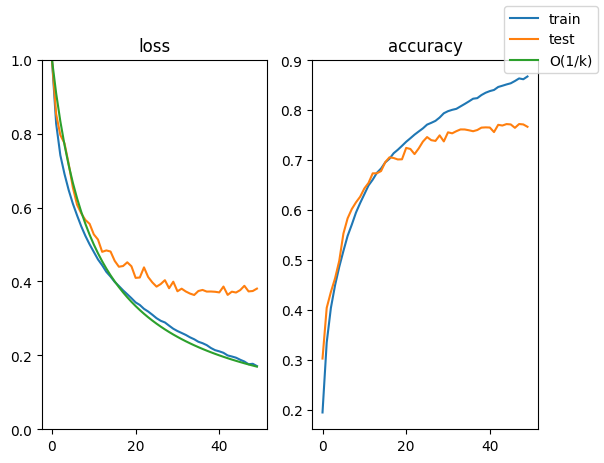

In [42]:
K=10
B = 10
x = np.linspace(0, EPOCHS-1)

fig1, (ax1,ax2) = plt.subplots(1,2)
train_loss = hist['train_loss']
test_loss = hist['test_loss']
ax1.plot(train_loss/train_loss[0], label='train')
ax1.plot(test_loss/test_loss[0], label='test')
ax1.plot(x, K/(x+B), label='O(1/k)')

ax1.set_ylim([0, 1])
ax2.plot(hist['train_acc'])
ax2.plot(hist['test_acc'])
ax1.set_title('loss')
ax2.set_title('accuracy')
fig1.legend()